In [0]:
# import packages for Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
! pip install emoji --upgrade
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
from google.colab import files
import emoji
import re
from pyspark.sql.types import StringType, ArrayType
import string
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
import pandas as pd
from pyspark.sql.functions import col, udf

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Venmo Word Classification Dictonary BAX-423 - Word_Dict.csv to Venmo Word Classification Dictonary BAX-423 - Word_Dict.csv
Saving Venmo_Emoji_Classification_Dictionary.csv to Venmo_Emoji_Classification_Dictionary.csv
Saving VenmoSample.snappy.parquet to VenmoSample.snappy.parquet


In [0]:
# Import Packages Locally
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.window import Window

import numpy as np

import pandas as pd

import string

import emoji

import re

from collections import Counter

In [0]:
spark = SparkSession\
        .builder\
        .appName('Venmo')\
        .getOrCreate()

In [0]:
venmo_data = spark\
            .read\
            .parquet("VenmoSample.snappy.parquet")

In [0]:
emoji = pd.read_csv('Venmo_Emoji_Classification_Dictionary.csv')
word = pd.read_csv('Venmo Word Classification Dictonary BAX-423 - Word_Dict.csv')

In [0]:
from pyspark import SparkContext as sc

In [0]:
venmo_data.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows



# Q1

In [0]:
tokenizer = Tokenizer(inputCol='description', outputCol='words')
tokenized = tokenizer.transform(venmo_data)

In [0]:
def df2dict(df):
    '''
    Convert dataframe to dictionary for further analysis
    '''
    cat_list = list(df.columns)
    cat_dict = {}
    for cat in cat_list:
        for word in df[cat]:
            cat_dict[word] = cat.strip()
    return cat_dict

emoji_dict = df2dict(emoji)
word_dict = df2dict(word)

In [0]:
def merge(dict1, dict2): 
    '''
    Merge emoji and words dictionaries
    '''
    res = {**dict1, **dict2} 
    return res 

dictionary = merge(emoji_dict, word_dict)

In [0]:
def str2category(string_list):
    '''
    Assign a category to the string
    '''
    category_list = [dictionary[string] for string in string_list if string in dictionary.keys()]
    if category_list == []:
        category_list.append('Others')
    return category_list

In [0]:
def most_common(score_dict):
    '''
    Return the category with the highest score
    '''
    return max(score_dict.keys(), key=score_dict.get)

In [0]:
def assign_one_cat(category_list):
    '''
    Assign one classification for a description by giving more weights to words(60%) than to emoji(40%)
    '''
    if len(category_list) == 1:
        category = category_list[0]
    else:
        score_dict = {x:0 for x in category_list}
        for topic in category_list:
            if topic in word_dict.keys():
                score_dict[topic] += 0.6
            else:
                score_dict[topic] += 0.4
        category = most_common(score_dict)
    return category

In [0]:
word_category = udf(lambda words: assign_one_cat(str2category(words)))
transaction_category = tokenized.withColumn('transaction', word_category(col('words')))
transaction_category.select(['description', 'transaction']).show()

+--------------------+---------------+
|         description|    transaction|
+--------------------+---------------+
|                Uber| Transportation|
|              Costco|           Food|
|        Sweaty balls|Illegal/Sarcasm|
|                  🎥|          Event|
|                   ⚡|        Utility|
|          Chipotlaid|         Others|
|     kitchen counter|        Utility|
|                Food|           Food|
|               Zaxby|         Others|
|           Fan sucks|         Others|
|                  👠|         Others|
|         Thanks babe|         People|
|                  🍺|           Food|
|                   ⛽| Transportation|
|Hey man  it's bee...|           Cash|
|         Getaway car| Transportation|
|     🔮 gypsy things|         Others|
|                  🔴|         Others|
|           Furniture|        Utility|
|bed bath mostly b...|        Utility|
+--------------------+---------------+
only showing top 20 rows



# Q2

In [0]:
def check4emoji(words_list):
    '''
    Check if the description only contains emoji
    '''
    emoji_list = []
    if words_list != []:
        summa = 0
        for word in words_list:
            if word.isalpha() == False and word not in string.punctuation:
                summa += 1
        if summa == len(words_list):
            emoji_or_not = 1
        else:
            emoji_or_not = 0
    return emoji_or_not

In [0]:
description = tokenized.select('description')
extract_emoji = udf(lambda words: check4emoji(words))
only_emoji = description.withColumn('emoji_or_not', extract_emoji(col('description')))
only_emoji.show(5)

+------------+------------+
| description|emoji_or_not|
+------------+------------+
|        Uber|           0|
|      Costco|           0|
|Sweaty balls|           0|
|          🎥|           1|
|           ⚡|           1|
+------------+------------+
only showing top 5 rows



In [0]:
emoji_records = only_emoji.filter(only_emoji.emoji_or_not == 1).count()
total_records = only_emoji.count()
round(emoji_records / total_records, 2)

0.26

__Top 5 popular emoji__

In [0]:
def find_all_emo(plain_text):
    if plain_text is None:
        return None
    emo_list = re.findall(escape_list, plain_text)
    return emo_list

In [0]:
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
escape_list = '|'.join(re.escape(p) for p in emojis_list)

search_all_emoji = udf(lambda y: find_all_emo(y), ArrayType(StringType()))
description_emoji = description.withColumn("emoji_in_post", search_all_emoji(col("description")))

In [0]:
description_emoji_rdd = description_emoji.rdd

popular_emoji = description_emoji_rdd.flatMap(lambda line: [emoji for emoji in line['emoji_in_post']]) \
                .map(lambda word: (word, 1)) \
                .reduceByKey(lambda x, y: x + y).collect()

In [0]:
popular_emoji_df = pd.DataFrame(popular_emoji, columns = ['emoji', 'num']).sort_values('num', ascending=False)
popular_emoji_df.reset_index(inplace=True, drop=True)
popular_emoji_df.iloc[:5]

,emoji,num
0,🍕,215039
1,🍻,145233
2,💸,124727
3,🍷,111157
4,🎉,94327


__Top 3 popular emoji categories__

In [0]:
emoji_category_list = list(set(emoji_dict.values())) + ['Others']

In [0]:
emoji_category = {x:0 for x in emoji_category_list}
for emo in popular_emoji_dict:
    if emo not in list(emoji_dict.keys()):
        emoji_category['Others'] += popular_emoji_dict[emo]
    else:
        emoji_category[emoji_dict[emo]] += popular_emoji_dict[emo]

In [0]:
emoji_category_df = pd.DataFrame(columns = ['category', 'num'])
emoji_category_df['category'] = emoji_category.keys()
emoji_category_df['num'] = emoji_category.values()
emoji_category_df.sort_values('num', ascending=False, inplace=True)
emoji_category_df.reset_index(inplace=True, drop=True)
emoji_category_df.iloc[:3]

,category,num
0,Others,1746006
1,Food,1744390
2,People,1006609


# Q3
### Static Spending Profile

In [0]:
## Get the number of transactions for each user within each category
## Since we want the user *spending* profile, we assume that each transaction only belongs to the user that paid
## i.e. transaction_type = "payment" -> user1, transaction_type = "charge" -> user2
transaction_category.createOrReplaceTempView("transaction_category")

trans_count = spark.sql("""
SELECT user, transaction, SUM(count) AS count
FROM (
SELECT user1 AS user, transaction, COUNT(*) AS count
FROM transaction_category
WHERE transaction_type = "payment"
GROUP BY user1, transaction
UNION ALL
SELECT user2 AS user, transaction, COUNT(*) AS count
FROM transaction_category
WHERE transaction_type = "charge"
GROUP BY user2, transaction) a
GROUP BY user, transaction
ORDER BY user, transaction
""")

In [0]:
trans_count.show(5)

+----+---------------+-----+
|user|    transaction|count|
+----+---------------+-----+
|   2|Illegal/Sarcasm|    1|
|   2|         Others|    2|
|   3|           Food|    1|
|   3|         Others|    3|
|   3|         People|    1|
+----+---------------+-----+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import sum
from pyspark.sql import Window


In [0]:
## Get the total number of transactions for each user
windowSpec = Window.partitionBy("user").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

trans_count2 = trans_count.withColumn("user_total", sum('count').over(windowSpec)).orderBy("user", "transaction")

In [0]:
from pyspark.sql.functions import count, bround

In [0]:
## Get the percantage for each category
trans_percentage = trans_count2.select(
    col("user"), \
    col("transaction"), \
    bround(100*col("count")/col("user_total")).alias("percentage"))

In [0]:
## Spread/Pivot the table to show one row of spending profile for each user
trans_spread = trans_percentage.groupBy("user").pivot("transaction").sum("percentage")
trans_spread.show(5)

+-----+--------+----+-----+-----+---------------+------+------+--------------+------+-------+
| user|Activity|Cash|Event| Food|Illegal/Sarcasm|Others|People|Transportation|Travel|Utility|
+-----+--------+----+-----+-----+---------------+------+------+--------------+------+-------+
| 2866|    null|null| null| null|           null| 100.0|  null|          null|  null|   null|
| 6620|    null|null| null| null|           null|  50.0|  null|          null|  50.0|   null|
|20735|    null|null| null|100.0|           null|  null|  null|          null|  null|   null|
|28170|    null|null| null| null|           null| 100.0|  null|          null|  null|   null|
|28759|    null|null| null| 33.0|           null|  33.0|  null|          null|  null|   33.0|
+-----+--------+----+-----+-----+---------------+------+------+--------------+------+-------+
only showing top 5 rows



### Static Spending Profile (One Variable)

In [0]:
## Combine each category and its percentage to form a single column of user spending profile
user_col = []
profile_col = []
for row in trans_spread.collect():
    for col in trans_spread.columns[1:11]:
        if row[col] != None:
            p = col + "(" + str(int(row[col])) + "%)"
            try:
                profile = profile + "+" + p
            except:
                profile = p
        else:
            continue
    profile_col.append(profile)
    user_col.append(row["user"])
    profile = None

In [0]:
## Insert result into a dataframe
profile_df = pd.DataFrame({"user": user_col, "profile": profile_col})
profile_df.head()

,user,profile
0,2866,Others(100%)
1,6620,Others(50%)+Travel(50%)
2,20735,Food(100%)
3,28170,Others(100%)
4,28759,Food(33%)+Others(33%)+Utility(33%)


In [0]:
## Convert pandas dataframe to spark dataframe
from pyspark.sql.types import StructType, StructField, LongType
mySchema = StructType([
StructField("user", LongType(), True), StructField("profile", StringType(), True)])
spending_profile = spark.createDataFrame(profile_df, schema = mySchema)
spending_profile.show()

+-----+--------------------+
| user|             profile|
+-----+--------------------+
| 2866|        Others(100%)|
| 6620|Others(50%)+Trave...|
|20735|          Food(100%)|
|28170|        Others(100%)|
|28759|Food(33%)+Others(...|
|33602|Activity(22%)+Cas...|
|36525|        Others(100%)|
|43714|        Others(100%)|
|45615|        Others(100%)|
|47283|Activity(33%)+Tra...|
|49331|        Others(100%)|
|51123|Others(33%)+Utili...|
|51415|Food(30%)+Others(...|
|53963|        Others(100%)|
|56680|Event(25%)+Others...|
|56741|        Others(100%)|
|58061|Others(50%)+Utili...|
|59990|Activity(50%)+Foo...|
|63087|Others(50%)+Utili...|
|64423|Food(25%)+Others(...|
+-----+--------------------+
only showing top 20 rows



# Q4
### Dynamic Spending Profile

In [0]:
## Get the time and transaction category for each user
transaction_category.createOrReplaceTempView("transaction_category")

trans_user = spark.sql("""
SELECT user1 AS user, datetime, transaction, date_format(datetime,'yyyy-MM-dd') AS date
FROM transaction_category
WHERE transaction_type = "payment"
UNION ALL
SELECT user2 AS user, datetime, transaction, date_format(datetime,'yyyy-MM-dd') AS date
FROM transaction_category
WHERE transaction_type = "charge"
""")

In [0]:
from pyspark.sql.functions import min
from pyspark.sql.functions import sum
from pyspark.sql import Window


In [0]:
## Get the date of each user's first transaction
windowSpec_time = Window.partitionBy("user").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
trans_user2 = trans_user.withColumn("first_date", min("datetime").over(windowSpec_time)).orderBy("user", "datetime")

In [0]:
## Lebel the time points from 0 to 12(30 days interval)
trans_user2.createOrReplaceTempView("trans_user2")

trans_user3 = spark.sql("""
SELECT user, time_point, transaction, COUNT(*) AS count
FROM (
SELECT user, transaction,
CASE 
WHEN datetime = first_date THEN 0
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30) THEN 1
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*2) THEN 2
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*3) THEN 3
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*4) THEN 4
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*5) THEN 5
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*6) THEN 6
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*7) THEN 7
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*8) THEN 8
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*9) THEN 9
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*10) THEN 10
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*11) THEN 11
WHEN date <= date_add(date_format(first_date, 'yyyy-MM-dd'), 30*12) THEN 12
ELSE 13
END AS time_point
FROM trans_user2) a
WHERE time_point < 13
GROUP BY user, time_point, transaction
ORDER BY user, time_point, transaction
""")

In [0]:
## Spread/Pivot the table to show one row of spending profile for each user within each time point
trans_spread_time = trans_user3.groupBy("user", "time_point").pivot("transaction").sum("count")
trans_spread_time = trans_spread_time.orderBy("user", "time_point")

In [0]:
## Convert the nulls to 0
trans_spread_time = trans_spread_time.na.fill(0)

In [0]:
## Show the spending profile for each user within each time point(not accumulated values)
trans_spread_time.show()

+----+----------+--------+----+-----+----+---------------+------+------+--------------+------+-------+
|user|time_point|Activity|Cash|Event|Food|Illegal/Sarcasm|Others|People|Transportation|Travel|Utility|
+----+----------+--------+----+-----+----+---------------+------+------+--------------+------+-------+
|   2|         0|       0|   0|    0|   0|              0|     1|     0|             0|     0|      0|
|   3|         0|       0|   0|    0|   0|              0|     0|     1|             0|     0|      0|
|   3|         1|       0|   0|    0|   1|              0|     3|     0|             0|     0|      1|
|   4|         0|       0|   0|    0|   1|              0|     0|     0|             0|     0|      0|
|   4|         1|       0|   0|    0|   1|              0|     0|     0|             0|     0|      0|
|   8|         0|       0|   0|    0|   1|              0|     0|     0|             0|     0|      0|
|   8|         7|       0|   0|    0|   0|              0|     1|     0| 

In [0]:
## Calculate the cumulative number of transactions for each user, time point and category
windowSpec_trans = Window.partitionBy("user").rowsBetween(Window.unboundedPreceding, Window.currentRow)

trans_cum = trans_spread_time

for col in trans_spread_time.columns[2:12]:
    trans_cum = trans_cum.withColumn(col+"_cum", sum(col).over(windowSpec_trans)).orderBy("user", "time_point")

In [0]:
## Rename the column
trans_cum = trans_cum.withColumnRenamed("Illegal/Sarcasm_cum", "IllegalOrSarcasm_cum")

In [0]:
## Select the columns with cumulative values
col_list = ["user","time_point","Activity_cum","Cash_cum","Event_cum","Food_cum","IllegalOrSarcasm_cum","Others_cum","People_cum","Transportation_cum","Travel_cum","Utility_cum"]
trans_cum = trans_cum.select(col_list)

In [0]:
## Calculate the total number of transactions for each user until each time point
trans_cum.createOrReplaceTempView("trans_cum")

trans_cum_total = spark.sql("""
SELECT t.*,
(Activity_cum+Cash_cum+Event_cum+Food_cum+IllegalOrSarcasm_cum+Others_cum+People_cum+Transportation_cum+Travel_cum+Utility_cum) AS user_all_total
FROM trans_cum t
""")

In [0]:
## Get the percentage for each category
trans_cum_total.createOrReplaceTempView("trans_cum_total")

trans_time_percentage = spark.sql("""
SELECT user, time_point,
COALESCE(ROUND(Activity_cum/user_all_total,2), 0) AS Activity,
COALESCE(ROUND(Cash_cum/user_all_total,2), 0) AS Cash,
COALESCE(ROUND(Event_cum/user_all_total,2), 0) AS Event,
COALESCE(ROUND(Food_cum/user_all_total,2), 0) AS Food,
COALESCE(ROUND(IllegalOrSarcasm_cum/user_all_total,2), 0) AS IllegalOrSarcasm,
COALESCE(ROUND(Others_cum/user_all_total,2), 0) AS Others,
COALESCE(ROUND(People_cum/user_all_total,2), 0) AS People,
COALESCE(ROUND(Transportation_cum/user_all_total,2), 0) AS Transportation,
COALESCE(ROUND(Travel_cum/user_all_total,2), 0) AS Travel,
COALESCE(ROUND(Utility_cum/user_all_total,2), 0) AS Utility
FROM trans_cum_total
ORDER BY user, time_point
""")

In [0]:
## Show the spending profile for each user until each time point(accumulated values -> percentage)
trans_time_percentage.show(5)

+----+----------+--------+----+-----+----+----------------+------+------+--------------+------+-------+
|user|time_point|Activity|Cash|Event|Food|IllegalOrSarcasm|Others|People|Transportation|Travel|Utility|
+----+----------+--------+----+-----+----+----------------+------+------+--------------+------+-------+
|   2|         0|     0.0| 0.0|  0.0| 0.0|             0.0|   1.0|   0.0|           0.0|   0.0|    0.0|
|   3|         0|     0.0| 0.0|  0.0| 0.0|             0.0|   0.0|   1.0|           0.0|   0.0|    0.0|
|   3|         1|     0.0| 0.0|  0.0|0.17|             0.0|   0.5|  0.17|           0.0|   0.0|   0.17|
|   4|         0|     0.0| 0.0|  0.0| 1.0|             0.0|   0.0|   0.0|           0.0|   0.0|    0.0|
|   4|         1|     0.0| 0.0|  0.0| 1.0|             0.0|   0.0|   0.0|           0.0|   0.0|    0.0|
+----+----------+--------+----+-----+----+----------------+------+------+--------------+------+-------+
only showing top 5 rows



### Plot the mean for each category surrounded by 2 standard deviation

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
## Get the sql script for each category to calculate the mean and standard deviation
## Only use the non-zero values
def category_script(category):
    script = "SELECT time_point, \
    ROUND(AVG("+category+")) AS avg, \
    ROUND(STDDEV("+category+")) AS sd \
    FROM trans_time_percentage \
    WHERE "+category+" > 0.0 \
    GROUP BY time_point \
    ORDER BY time_point"
    return script

In [0]:
## Plot the average user's dynamic percantage for each category
def avg_plot(df, category):
    plt.plot(df["time_point"], df["avg"])
    plt.fill_between(df["time_point"], (df["avg"]-2*df["sd"]), (df["avg"]+2*df["sd"]), color='b', alpha=.1)
    plt.title(category)
    plt.xlabel("Time Point")
    plt.ylabel("Average Percentage(%)")
    plt.xticks(np.arange(0, 13, step = 1))

In [0]:
trans_time_percentage.registerTempTable("trans_time_percentage")

In [0]:
## Calculate the mean and standard deviation for each category and store in a list
category_list = list()
for col in trans_time_percentage.columns[2:12]:
    category_avg_sd = spark.sql(category_script(col))
    category_df = category_avg_sd.toPandas()
    category_list.append(category_df)

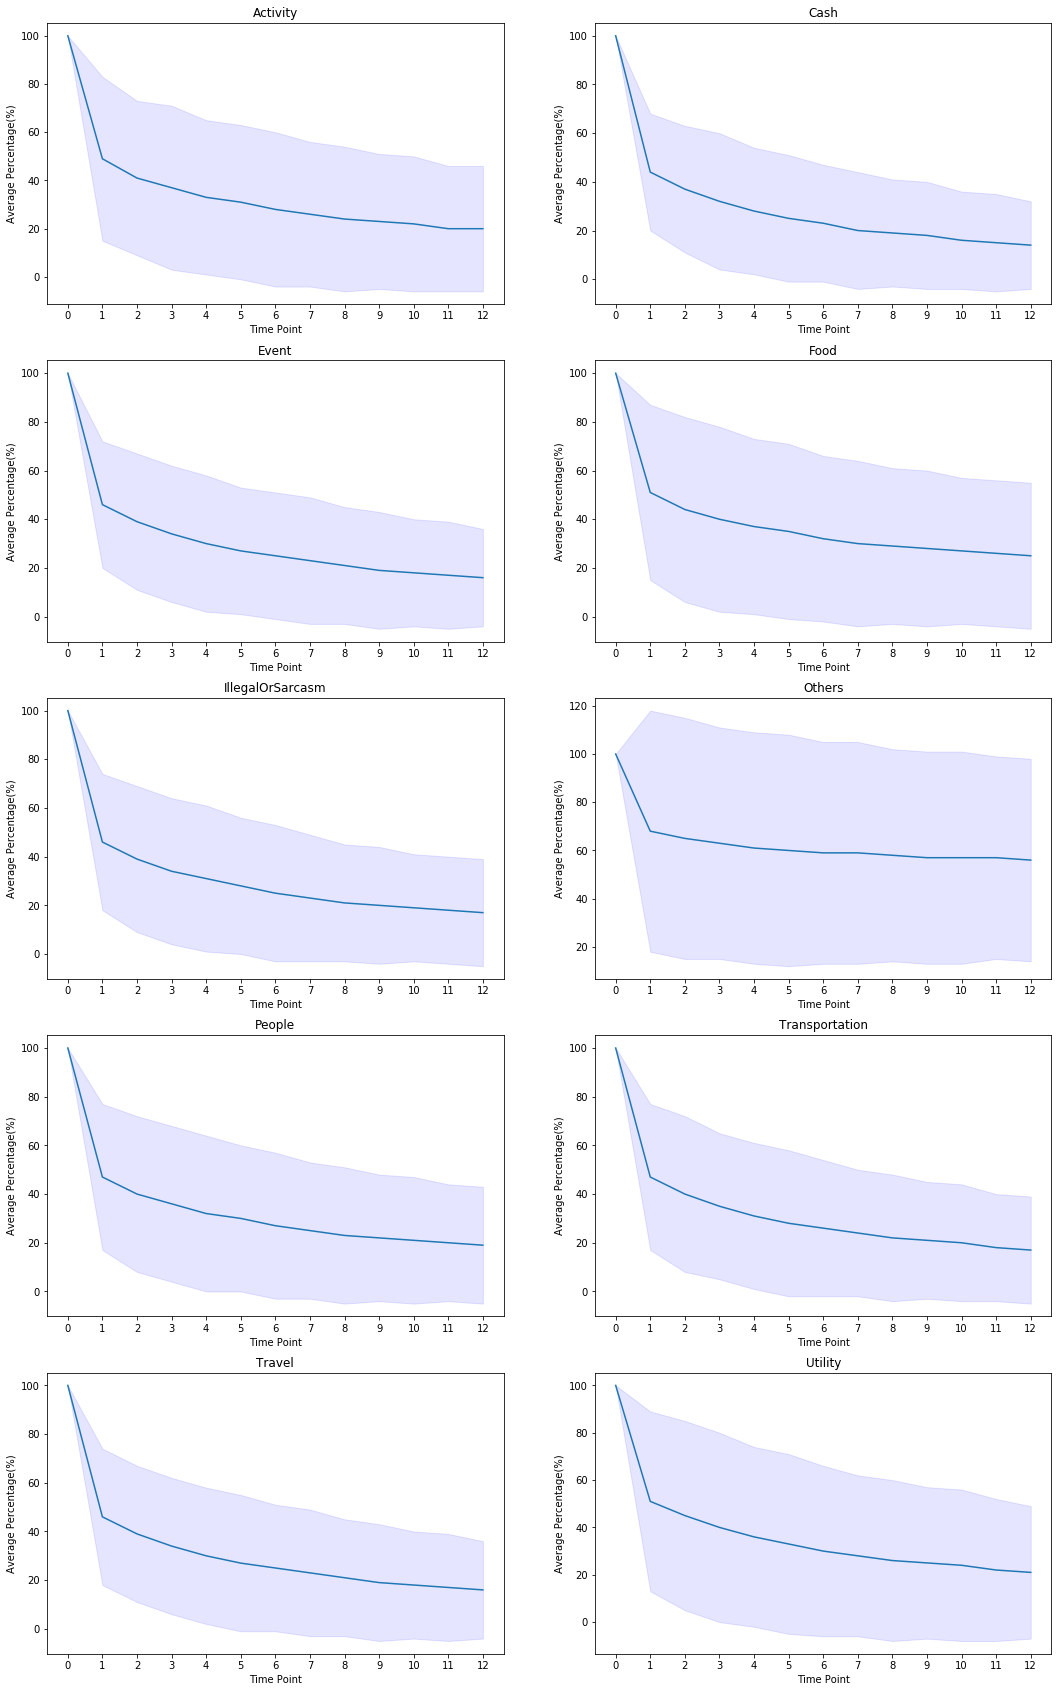

In [0]:
## Plot the mean for each category surrounded by 2 standard deviation
fig, ax = plt.subplots(figsize = (18,30))

for i in range(0, 10):
    plt.subplot(5,2,i+1)
    plot = avg_plot(category_list[i], trans_time_percentage.columns[i+2])

# Q5

In [0]:
venmo_rdd = venmo_data.select(['user1', 'user2', 'datetime']).rdd

__Find users' friends__

In [0]:
def mapping(p_id, records):
    output = []
    for row in records:
        output.append((row['user1'], set([row['user2']])))
        output.append((row['user2'], set([row['user1']])))
    return output

In [0]:
outputs = venmo_rdd.mapPartitionsWithIndex(mapping).reduceByKey(lambda x, y: x|y).collect()

In [0]:
friends = {}
for row in outputs:
    friends[row[0]] = list(row[1])

In [0]:
# Print the first five users' friends
for user in list(friends.keys())[:5]:
    print ('The friends of User', user, 'are: ', friends[user])

The friends of User 622512 are:  [6818944, 362336, 915939, 1550756, 764423, 1755239, 1149001, 5159592, 1710283, 353005, 1866541, 863695, 1503666, 349365, 3846837, 1402170]
The friends of User 4705808 are:  [2177733, 4158854]
The friends of User 3354352 are:  [5605124, 1508870, 6422151, 5811949, 839317]
The friends of User 690992 are:  [2139842, 698852, 1393513, 2902860, 536941, 495790, 734990]
The friends of User 2199464 are:  [1768352, 747910, 2216679, 2352617, 3227657, 2818808, 1834715]


__Find users' friends of friends__

In [0]:
def remove_sublist(full_list,sub_list):
    '''
    Remove friends of the user to only include friends of friends
    '''
    return list(set(full_list) - set(sub_list))

In [0]:
fof_dict = {}
for user in friends.keys():
    friends_list = map(friends.get, friends[user])
    fof = []
    # Loop through the list of friends for the user
    for friend in friends_list:
        fof += friend
    unique_fof = list(set(fof))
    unique_fof.remove(user)
    fof_dict[user] = remove_sublist(unique_fof, friends[user])

In [0]:
# Print the first five users' friends of friends
for user in list(fof_dict.keys())[:5]:
    print ('The friends of User', user, 'are: ', fof_dict[user])

The friends of User 622512 are:  [1127425, 1388550, 1292551, 1619719, 634638, 211727, 328213, 608789, 933655, 566553, 1462044, 630561, 916515, 933924, 1707045, 3654448, 2439986, 8016694, 1457974, 508985, 849980, 470589, 2793789, 254015, 2287422, 3746116, 809797, 305479, 4241740, 640589, 1120849, 3354706, 1149011, 1642068, 3730260, 7216729, 848986, 6655067, 409434, 3695968, 1305204, 324222, 3636095, 349313, 491139, 2494341, 5687686, 3120264, 320652, 770956, 679054, 1317773, 625558, 7411351, 1351577, 497563, 5947293, 1512351, 8620961, 256162, 416419, 1754788, 970147, 7457959, 1057704, 1032618, 956920, 371377, 3264433, 666549, 2543288, 6454202, 483775, 2495424, 1608129, 1607621, 916684, 1057237, 1150680, 574936, 433630, 1838564, 2896613, 1769704, 7614955, 353004, 1239790, 927984, 353009, 2299123, 6162675, 2435830, 342262, 3374328, 340470, 451580, 1446654]
The friends of User 4705808 are:  [1842771, 8823869, 3195525, 4699631]
The friends of User 3354352 are:  [1177477, 447248, 3383568, 235

# Q6

In [0]:
# pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import *
import networkx as nx

In [0]:
MAX_MEMORY = "6g"

In [0]:
spark = SparkSession\
        .builder\
        .appName("Venmo")\
        .config("spark.executor.memory",MAX_MEMORY)\
        .config("spark.driver.memory",MAX_MEMORY)\
        .getOrCreate()
venmo_data = sqlContext.read.parquet("VenmoSample.snappy.parquet")

In [0]:
df_crm_user1 = venmo_data.select("user1","user2", "transaction_type","datetime")
df_crm_user2 = venmo_data.select("user2","user1","transaction_type","datetime")

In [0]:
df_crm = df_crm_user1.union(df_crm_user2).orderBy("user1")

w = Window.partitionBy("user1")
df_crm2 = df_crm.withColumn("min_date", F.min("datetime").over(w))

df_crm2.createOrReplaceTempView("df_crm2")

df_crm3 = spark.sql("""
SELECT user1, user2, datetime, date_format(min_date,'yyyy-MM-dd') AS min_date, date_format(datetime,'yyyy-MM-dd') AS date,transaction_type
FROM df_crm2
""")
# df_crm3.show(5)

In [0]:
df_mindate = df_crm3.select("user1", "min_date").dropDuplicates()
# df_mindate.show(10)

In [0]:
# convert df_mindate into mindate_dict
mindate_rdd = df_mindate.rdd.map(lambda x : (x[0],x))
mindate_dict = mindate_rdd.collectAsMap()

In [0]:
user_list = [key for key in mindate_dict.keys()]
# len(user_list)

In [0]:
def mapping(p_id, records):
    output = []
    for row in records:
        output.append((row['user1'], set([row['user2']])))
        output.append((row['user2'], set([row['user1']])))
    return output

def remove_sublist(full_list,sub_list):
    '''
    Remove friends of the user to only include friends of friends
    '''
    return list(set(full_list) - set(sub_list))

def create_f_dict(df):
    venmo_rdd = df.select(['user1', 'user2', 'datetime']).rdd
    outputs = venmo_rdd.mapPartitionsWithIndex(mapping).reduceByKey(lambda x, y: x|y).collect()
    friends = {}
    for row in outputs:
        friends[row[0]] = list(row[1])
    return friends

def create_fof_dict(friends):
    fof_dict = {}
    for user in friends.keys():
        friends_list = map(friends.get, friends[user])
        fof = []
        for friend in friends_list:
            fof += friend
        unique_fof = list(set(fof))
        unique_fof.remove(user)
        fof_dict[user] = remove_sublist(unique_fof, friends[user])
    return fof_dict 
  

In [0]:
DF_list = []
# loop from t0 to t12
for t in range(12):
#     print(t)
    add_days = t * 30
    all_user_at_t = []
    for user_num in user_list:
#         print(user_num)
        # find user's corresponding min_date
        minDate = mindate_dict.get(user_num)['min_date']
        df = df_crm3.where(col("date") <= date_add(lit(minDate),add_days))
        friends = create_f_dict(df)
        fof_dict = create_fof_dict(friends)

        user_dict = {}
        num_f = len(friends[user_num])
        num_fof = len(fof_dict[user_num]) 
        G = nx.Graph(friends)
        cluster_ceof = nx.clustering(G)
        cc = cluster_ceof[user_num]
        pagerank = nx.pagerank(G,0.4)
        pr = pagerank[user_num]
        user_dict['user'] = user_num
        user_dict['time_spot'] = t
        user_dict['num_friend'] = num_f
        user_dict['num_fof'] = num_fof
        user_dict['cluster_coef'] = cc
        user_dict['page_rank'] = pr
        all_user_at_t.append(user_dict)
    myJson = sc.parallelize(all_user_at_t)
    myDf = sqlContext.read.json(myJson)
    DF_list.append(myDf)
        

# Q7 

In [0]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import *

In [0]:
venmo_data.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows



In [0]:
df_crm_user1 = venmo_data.select("user1", "datetime").withColumnRenamed('user1', 'user')
df_crm_user2 = venmo_data.select("user2", "datetime").withColumnRenamed('user2', 'user')

In [0]:
df_crm_user1.orderBy("user1").show(5)

+----+-------------------+
|user|           datetime|
+----+-------------------+
|   2|2012-11-23 06:03:42|
|   3|2016-09-22 15:30:09|
|   3|2016-10-07 23:37:56|
|   3|2016-10-06 10:49:45|
|   3|2016-10-09 01:56:24|
+----+-------------------+
only showing top 5 rows



In [0]:
df_crm_user2.orderBy("user2").show(5)

+----+-------------------+
|user|           datetime|
+----+-------------------+
|   2|2016-04-09 09:29:31|
|   2|2016-09-26 09:56:55|
|   2|2016-09-07 07:53:16|
|   3|2016-07-22 21:16:37|
|   3|2016-10-29 09:28:07|
+----+-------------------+
only showing top 5 rows



In [0]:
df_crm = df_crm_user1.union(df_crm_user2).orderBy("user")
df_crm.show(5)

+----+-------------------+
|user|           datetime|
+----+-------------------+
|   2|2016-09-26 09:56:55|
|   2|2012-11-23 06:03:42|
|   2|2016-04-09 09:29:31|
|   2|2016-09-07 07:53:16|
|   3|2016-10-09 01:56:24|
+----+-------------------+
only showing top 5 rows



In [0]:
df_crm = df_crm.withColumn('unix_time', F.unix_timestamp('datetime', 'yyyy-MM-dd'))

winSpec = Window.partitionBy('user').orderBy('unix_time').rangeBetween(0, 365*86400)

df_Y = df_crm.withColumn('count_12_month', F.count('user').over(winSpec))

df_Y = df_Y.orderBy('user', 'datetime')

In [0]:
w = Window.partitionBy("user")
df_Y = df_Y.withColumn("min_date", F.min("datetime").over(w))\
            .where(col("datetime") == col("min_date"))\
            .drop("min_date").orderBy("user")

In [0]:
df_Y.show(10, False)

+----+-------------------+----------+--------------+
|user|datetime           |unix_time |count_12_month|
+----+-------------------+----------+--------------+
|2   |2012-11-23 06:03:42|1353650622|1             |
|3   |2016-06-27 01:14:37|1466990077|9             |
|4   |2012-12-03 03:35:53|1354505753|4             |
|6   |2014-06-28 00:18:16|1403914696|2             |
|8   |2015-08-11 02:08:47|1439258927|6             |
|9   |2012-06-28 04:28:32|1340857712|5             |
|10  |2012-11-25 09:20:39|1353835239|12            |
|11  |2012-05-15 22:08:58|1337119738|13            |
|12  |2012-09-01 03:40:16|1346470816|5             |
|13  |2012-09-28 06:11:39|1348812699|5             |
+----+-------------------+----------+--------------+
only showing top 10 rows



# Q8

In [0]:
df_crm.show(5, False)

+----+-------------------+----------+
|user|datetime           |unix_time |
+----+-------------------+----------+
|2   |2016-09-26 09:56:55|1474883815|
|2   |2012-11-23 06:03:42|1353650622|
|2   |2016-04-09 09:29:31|1460194171|
|2   |2016-09-07 07:53:16|1473234796|
|3   |2016-10-09 01:56:24|1475978184|
+----+-------------------+----------+
only showing top 5 rows



In [0]:
from tqdm import tqdm
df_X_list = []
for life_pt in tqdm(range(13)):
    w = Window.partitionBy("user").orderBy("datetime")
    df_X = df_crm.withColumn("eol", min("datetime").over(w) + expr('INTERVAL {} MONTHS'.format(life_pt))) \
                .where(col("datetime") <= col("eol")) \
                .withColumn("recency", expr("datediff(eol, datetime)"))
    df_X = df_X.withColumn("time_elapse", max("recency").over(w) + 1)
    df_X = df_X.withColumn("total", row_number().over(w))
    df_X = df_X.groupBy("user").agg(
            min("recency").alias("recency"), (max("total").cast('float')/max("time_elapse").cast('float')).alias("frequency"))
    df_X.orderBy("user").show(10)
    df_X_list.append(df_X)

  8%|▊         | 1/13 [00:20<04:10, 20.85s/it]

+----+-------+---------+
|user|recency|frequency|
+----+-------+---------+
|   2|      0|      1.0|
|   3|      0|      1.0|
|   4|      0|      1.0|
|   6|      0|      1.0|
|   8|      0|      1.0|
|   9|      0|      1.0|
|  10|      0|      1.0|
|  11|      0|      1.0|
|  12|      0|      1.0|
|  13|      0|      1.0|
+----+-------+---------+
only showing top 10 rows



 15%|█▌        | 2/13 [00:42<03:51, 21.03s/it]

+----+-------+-------------------+
|user|recency|          frequency|
+----+-------+-------------------+
|   2|     30|0.03225806451612903|
|   3|      5|0.06451612903225806|
|   4|     19|            0.09375|
|   6|     30|0.03225806451612903|
|   8|     31|            0.03125|
|   9|     30|0.03225806451612903|
|  10|      2|0.06451612903225806|
|  11|     22|             0.0625|
|  12|     30|0.03225806451612903|
|  13|     30|0.03225806451612903|
+----+-------+-------------------+
only showing top 10 rows



 23%|██▎       | 3/13 [01:04<03:32, 21.25s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|     61|0.016129032258064516|
|   3|     36| 0.03225806451612903|
|   4|     30| 0.06349206349206349|
|   6|     61|0.016129032258064516|
|   8|     21| 0.03225806451612903|
|   9|     15| 0.03225806451612903|
|  10|     11| 0.08064516129032258|
|  11|     52| 0.03225806451612903|
|  12|     29| 0.03225806451612903|
|  13|     30| 0.03225806451612903|
+----+-------+--------------------+
only showing top 10 rows



 31%|███       | 4/13 [01:25<03:13, 21.45s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|     92|0.010752688172043012|
|   3|      5| 0.03225806451612903|
|   4|     58| 0.04395604395604396|
|   6|     92|0.010752688172043012|
|   8|     52|0.021505376344086023|
|   9|     46|0.021505376344086023|
|  10|     42|0.053763440860215055|
|  11|      5| 0.03225806451612903|
|  12|     59|0.021739130434782608|
|  13|     60|0.021739130434782608|
+----+-------+--------------------+
only showing top 10 rows



 38%|███▊      | 5/13 [01:48<02:53, 21.70s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    120|0.008264462809917356|
|   3|     18| 0.06504065040650407|
|   4|     89| 0.03278688524590164|
|   6|    122|0.008130081300813009|
|   8|     82|0.016260162601626018|
|   9|     76|0.016260162601626018|
|  10|     14| 0.05785123966942149|
|  11|     21| 0.03225806451612903|
|  12|     90|0.016260162601626018|
|  13|     91|0.016260162601626018|
+----+-------+--------------------+
only showing top 10 rows



 46%|████▌     | 6/13 [02:11<02:34, 22.06s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    151|0.006578947368421052|
|   3|     29| 0.05844155844155844|
|   4|    119| 0.02631578947368421|
|   6|    153|0.006493506493506494|
|   8|    113|0.012987012987012988|
|   9|     18| 0.01948051948051948|
|  10|     12| 0.05921052631578947|
|  11|      2|0.045454545454545456|
|  12|    121|0.012987012987012988|
|  13|    122|0.012987012987012988|
+----+-------+--------------------+
only showing top 10 rows



 54%|█████▍    | 7/13 [02:34<02:14, 22.47s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    181|0.005494505494505495|
|   3|     59| 0.04891304347826087|
|   4|    150| 0.02185792349726776|
|   6|    183|0.005434782608695652|
|   8|      1|0.016216216216216217|
|   9|     48|0.016304347826086956|
|  10|     42| 0.04945054945054945|
|  11|     33| 0.03783783783783784|
|  12|     18|0.016483516483516484|
|  13|      7|0.016483516483516484|
+----+-------+--------------------+
only showing top 10 rows



 62%|██████▏   | 8/13 [02:58<01:54, 22.81s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    212|0.004694835680751174|
|   3|     90| 0.04186046511627907|
|   4|    180|0.018779342723004695|
|   6|    214|0.004651162790697674|
|   8|      9|0.018691588785046728|
|   9|     31|0.018604651162790697|
|  10|     73| 0.04225352112676056|
|  11|      1| 0.05116279069767442|
|  12|     49|0.014084507042253521|
|  13|     15|0.018779342723004695|
+----+-------+--------------------+
only showing top 10 rows



 69%|██████▉   | 9/13 [03:22<01:32, 23.25s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    242| 0.00411522633744856|
|   3|    121|0.036585365853658534|
|   4|    211| 0.01639344262295082|
|   6|    245|0.004065040650406...|
|   8|     40|  0.0163265306122449|
|   9|     10| 0.02032520325203252|
|  10|    103|0.037037037037037035|
|  11|     23| 0.04878048780487805|
|  12|     79|0.012345679012345678|
|  13|     45| 0.01646090534979424|
+----+-------+--------------------+
only showing top 10 rows



 77%|███████▋  | 10/13 [03:46<01:10, 23.61s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    273|0.003649635036496...|
|   3|    149|0.032846715328467155|
|   4|    242|0.014545454545454545|
|   6|    273|0.003649635036496...|
|   8|     23| 0.01818181818181818|
|   9|     38| 0.01824817518248175|
|  10|     31|  0.0364963503649635|
|  11|     54| 0.04332129963898917|
|  12|     26|0.014598540145985401|
|  13|     76|0.014598540145985401|
+----+-------+--------------------+
only showing top 10 rows



 85%|████████▍ | 11/13 [04:11<00:47, 23.92s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    304|0.003278688524590164|
|   3|    180|0.029508196721311476|
|   4|    272|0.013114754098360656|
|   6|     14|0.006557377049180328|
|   8|     25|  0.0196078431372549|
|   9|     69| 0.01639344262295082|
|  10|     11|0.036065573770491806|
|  11|     82| 0.03934426229508197|
|  12|     56|0.013157894736842105|
|  13|     17| 0.01644736842105263|
+----+-------+--------------------+
only showing top 10 rows



 92%|█████████▏| 12/13 [04:36<00:24, 24.19s/it]

+----+-------+--------------------+
|user|recency|           frequency|
+----+-------+--------------------+
|   2|    334|0.002985074626865...|
|   3|    210|0.026865671641791045|
|   4|    303|0.011904761904761904|
|   6|     44|0.005970149253731343|
|   8|     55|0.017857142857142856|
|   9|     99|0.014925373134328358|
|  10|     19| 0.03582089552238806|
|  11|     25| 0.03869047619047619|
|  12|     87|0.011940298507462687|
|  13|     48|0.014925373134328358|
+----+-------+--------------------+
only showing top 10 rows



100%|██████████| 13/13 [05:01<00:00, 23.20s/it]

+----+-------+-------------------+
|user|recency|          frequency|
+----+-------+-------------------+
|   2|    365|0.00273224043715847|
|   3|    241|0.02459016393442623|
|   4|    333|0.01092896174863388|
|   6|     75|0.00546448087431694|
|   8|     86|0.01634877384196185|
|   9|    130|0.01366120218579235|
|  10|     50|0.03278688524590164|
|  11|     55|0.03551912568306011|
|  12|     30|0.01366120218579235|
|  13|     79|0.01366120218579235|
+----+-------+-------------------+
only showing top 10 rows



In [0]:
df_X_list

[DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double],
 DataFrame[user: int, recency: int, frequency: double]]

# Q9

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [0]:
def linear_reg_mse(df_lr):

    assembler = VectorAssembler(inputCols = ['recency', 'frequency'], outputCol = 'features')
    output = assembler.transform(df_lr)
    finalData = output.select('features', 'count_12_month')

    trainData, testData = finalData.randomSplit([0.7,0.3])
    lrModel = LinearRegression(labelCol='count_12_month', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)

    testResults = lrEstimator.evaluate(testData)
    MSE = testResults.rootMeanSquaredError
    return MSE

In [0]:
mse_list = []
for ti in tqdm(range(13)):
    df_X_ti = df_X_list[ti]
    df_lr_ti = df_Y.join(df_X_ti, on=['user'], how='inner')
    mse_ti = linear_reg_mse(df_lr_ti)
    mse_list.append(mse_ti)


100%|██████████| 13/13 [13:26<00:00, 62.02s/it]


In [0]:
mse_list

[3.3467970660470967,
 3.0281527360606653,
 2.755113612541959,
 2.5824357773067357,
 2.2831154329604426,
 1.9920854403540438,
 1.7699727142414279,
 1.503418827620764,
 1.2589138875258126,
 1.0187396181013864,
 0.7641195657820166,
 0.4929011182742553,
 0.05487989889351261]

## Plot the MSEs of the regressions

Text(0, 0.5, 'MSE')

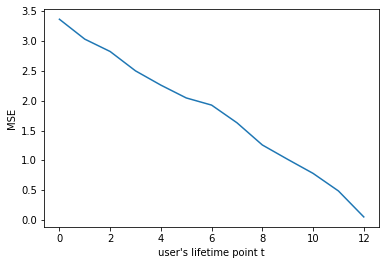

In [0]:
plt.plot(mse_list)
plt.xlabel("user's lifetime point t")
plt.ylabel("MSE")

# Q10 A 

In [0]:
from tqdm import tqdm
df_spend_list = []
for life_pt in tqdm(range(13)):
    df_spend = trans_time_percentage.filter(trans_time_percentage.time_point == life_pt) #.drop("time_point")
    df_spend_list.append(df_spend)

100%|██████████| 13/13 [00:00<00:00, 117.75it/s]


In [0]:
df_rf_list = df_X_list
df_rf_spend_list = []
for ti in tqdm(range(13)):
    df_rf_spend_ti = df_spend_list[ti].join(df_rf_list[ti], on = ['user'], how = 'inner')
    df_rf_spend_list.append(df_rf_spend_ti)

100%|██████████| 13/13 [00:00<00:00, 61.42it/s]


In [0]:
df_rf_spend_list[0].show(5)

In [0]:
input_rf_spend = ['recency', 'frequency', 'Activity', 'Cash', 'Event', 'Food', 'IllegalOrSarcasm', 'Others', 'People','Transportation', 'Travel', 'Utility'  ]

In [0]:
def linear_reg_mse2(df_lr):

    assembler = VectorAssembler(inputCols = input_rf_spend, outputCol = 'features')
    output = assembler.transform(df_lr)
    finalData = output.select('features', 'count_12_month')

    trainData, testData = finalData.randomSplit([0.7,0.3])
    lrModel = LinearRegression(labelCol='count_12_month', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)

    testResults = lrEstimator.evaluate(testData)
    MSE = testResults.rootMeanSquaredError
    return MSE

In [0]:
# code for running 13 models on all data
mse_list_rf_spend = []
for ti in tqdm(range(13)):
   df_rf_spend_ti = df_rf_spend_list[ti]
   df_lr_ti = df_Y.join(df_rf_spend_ti, on=['user'], how='inner')
   mse_ti = linear_reg_mse2(df_lr_ti)
   print(str(ti)+": ",mse_ti)
   mse_list_rf_spend.append(mse_ti)

In [0]:
mse_list_rf_spend

In [0]:
# code for running 13 models on users with user<3000


# mse_list_rf_spend = []
# for ti in tqdm(range(13)):
#   df_rf_spend_ti = df_rf_spend_list[ti]
#   df_lr_ti = df_Y.join(df_rf_spend_ti, on=['user'], how='inner')
#   df_lr_ti = df_lr_ti.filter(df_lr_ti.user < 3000)
#   mse_ti = linear_reg_mse2(df_lr_ti)
#   print(str(ti)+": ",mse_ti)
#   mse_list_rf_spend.append(mse_ti)

# to compare regression with rf and regression with rf & spend on the same level 
# run regression with rf again on user<3000
# mse_list = []
# for ti in tqdm(range(13)):
#     df_X_ti = df_X_list[ti]
#     df_lr_ti = df_Y.join(df_X_ti, on=['user'], how='inner')
#     df_lr_ti = df_lr_ti.filter(df_lr_ti.user < 3000)
#     mse_ti = linear_reg_mse(df_lr_ti)
#     mse_list.append(mse_ti)

# mse_list

# Q10 B 

In [0]:
pip install sparkpickle

  Created wheel for sparkpickle: filename=sparkpickle-1.0.1-cp36-none-any.whl size=27389 sha256=f5ff1b10986dd0494c017ea1a73a62a398875e1b23dd6ad9ab94d84ed184601e
  Stored in directory: /root/.cache/pip/wheels/81/83/f7/189f6eda49941039142c83e56e711a956068009daaff49acb0
Successfully built sparkpickle


In [0]:
import re
import zipfile
from google.colab import files
from io import BytesIO
import pandas as pd
import sparkpickle

In [0]:
# code for running models on all data
# read social network metrics from a pickle profile saved to the local directory
def zip_extract(x):
   file_obj = zipfile.ZipFile(x, "a")
   files = [i for i in file_obj.namelist()]
   return dict(zip(files, [file_obj.open(file).read() for file in files]))

In [0]:
def extract_pickle(zip_dictionary):
for filename in zip_dictionary.keys():
   if re.findall(r".*[0-9]$",filename):
     mylist = sparkpickle.load(BytesIO(zip_dictionary[filename]))
     try:
       mydf
     except:
       mydf = spark.createDataFrame(mylist)  
    else:
       specific_df = spark.createDataFrame(mylist)  
       mydf = mydf.unionAll(specific_df)
 return mydf

In [0]:
uploaded = files.upload()

In [0]:
zip_dictionary_social = zip_extract(DF_list)
df_social = extract_pickle(DF_list)

In [0]:
def linear_reg_mse3(df_lr):

   assembler = VectorAssembler(inputCols = input_social, outputCol = 'features')
   output = assembler.transform(df_lr)
   finalData = output.select('features', 'count_12_month')

   trainData, testData = finalData.randomSplit([0.7,0.3])
   lrModel = LinearRegression(labelCol='count_12_month', featuresCol='features')
   lrEstimator = lrModel.fit(trainData)

   testResults = lrEstimator.evaluate(testData)
   MSE = testResults.rootMeanSquaredError
   return MSE

In [0]:
input_social = ['cluster_coef', 'num_fof', 'num_friend', 'page_rank']

In [0]:
mse_list_social = []
for ti in tqdm(range(13)):
   df_social_ti = df_social[ti]
   df_lr_ti = df_Y.join(df_social_ti, on=['user'], how='inner')
   mse_ti = linear_reg_mse(df_lr_ti)
   mse_list_social.append(mse_ti)

In [0]:
mse_list_social

# Q11 

In [0]:
input_social_spend = ['cluster_coef', 'num_fof', 'num_friend', 'page_rank', 'Activity', 'Cash', 'Event', 'Food', 'IllegalOrSarcasm', 'Others', 'People','Transportation', 'Travel', 'Utility' ]

In [0]:
def linear_reg_mse4(df_lr):

   assembler = VectorAssembler(inputCols = input_social_spend, outputCol = 'features')
   output = assembler.transform(df_lr)
   
   finalData = output.select('features', 'count_12_month')
   trainData, testData = finalData.randomSplit([0.7,0.3])
   lrModel = LinearRegression(labelCol='count_12_month', featuresCol='features')
   lrEstimator = lrModel.fit(trainData)

   testResults = lrEstimator.evaluate(testData)
   MSE = testResults.rootMeanSquaredError
   return MSE

In [0]:
# code for all data
# run regression on all data
mse_list_social_spend = []
for ti in tqdm(range(13)):
   df_social_spend_ti = df_social[ti].join(df_spend_list[ti], on=['user'], how='inner)
   df_lr_ti = df_Y.join(df_social_spend_ti, on=['user'], how='inner')
   mse_ti = linear_reg_mse4(df_lr_ti)
   print(str(ti)+": ",mse_ti)
   mse_list_social_spend.append(mse_ti)